## Imports

In [33]:
import torch, torchvision
import numpy as np
import matplotlib.pyplot as plt

In [25]:
MNIST_train = torchvision.datasets.MNIST("./data", train=True, download=True)
MNIST_test = torchvision.datasets.MNIST("./data", train=False, download=True)

x_train = MNIST_train.data.flatten(1).int() / 255
y_train = MNIST_train.targets.int()

x_test = MNIST_test.data.flatten(1).int() / 255
y_test = MNIST_test.targets.int()

In [26]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = torch.nn.Linear(input_size, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, hidden_size)
        self.linear3 = torch.nn.Linear(hidden_size, hidden_size)
        self.linear4 = torch.nn.Linear(hidden_size, output_size)
        self.act = torch.nn.ReLU()

    def forward(self, x):
        x = self.act(self.linear1(x))
        x = self.act(self.linear2(x))
        x = self.act(self.linear3(x))
        x = self.linear4(x)
        return x

In [27]:
dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

In [28]:
import time
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NeuralNetwork(784, 300, 10)
model = model.to(device)
model.load_state_dict(gpu_params)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

start = time.time()
for epoch in range(num_epochs):
    b_x, b_y = next(iter(train_loader))
    b_x = b_x.float().to(device)
    b_y = b_y.long().to(device)
    output = model(b_x)
    loss = loss_fn(output, b_y)
    optimizer.zero_grad()
    #loss.backward()
    #optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {(output.argmax(1) == b_y).float().mean():.4f}")

print(f"Time: {time.time() - start:.2f} seconds")


Epoch 10/100, Loss: 0.3604, Accuracy: 0.9100
Epoch 20/100, Loss: 0.4855, Accuracy: 0.8100
Epoch 30/100, Loss: 0.5038, Accuracy: 0.8400
Epoch 40/100, Loss: 0.4134, Accuracy: 0.9000
Epoch 50/100, Loss: 0.3810, Accuracy: 0.9100
Epoch 60/100, Loss: 0.4963, Accuracy: 0.8400
Epoch 70/100, Loss: 0.5099, Accuracy: 0.8800
Epoch 80/100, Loss: 0.5335, Accuracy: 0.7800
Epoch 90/100, Loss: 0.3637, Accuracy: 0.9100
Epoch 100/100, Loss: 0.3913, Accuracy: 0.8800
Time: 0.18 seconds


## Test predictions for pre-trained

### Loading GPU and CPU weights and Biases

In [29]:
save_dir = "model_saves/"
names = ["w1", "w2", "w3", "w4", "b1", "b2", "b3", "b4"]
torch_names = ["linear1.weight", "linear2.weight", "linear3.weight", "linear4.weight", "linear1.bias", "linear2.bias", "linear3.bias", "linear4.bias"]
cpu_params ={}
gpu_params = {}

for reg_name, torch_name in zip(names, torch_names):
    gpu_param = np.loadtxt(save_dir + reg_name + "_gpu.csv", delimiter=",")
    cpu_param = np.loadtxt(save_dir + reg_name + "_cpu.csv", delimiter=",")
    gpu_params[torch_name] = torch.tensor(gpu_param.T)
    cpu_params[torch_name] = torch.tensor(cpu_param.T)



In [32]:
cpu_net = NeuralNetwork(784, 300, 10)
cpu_net.load_state_dict(cpu_params)

gpu_net = NeuralNetwork(784, 300, 10)
gpu_net.load_state_dict(gpu_params)

random_5_idx = np.random.choice(len(x_test), 5, replace=False)
x_in = x_test[random_5_idx].float()
y_in = y_test[random_5_idx].long()

cpu_out = cpu_net(x_in)
gpu_out = gpu_net(x_in)

cpu_pred = cpu_out.argmax(1)
gpu_pred = gpu_out.argmax(1)

## Printing predictions

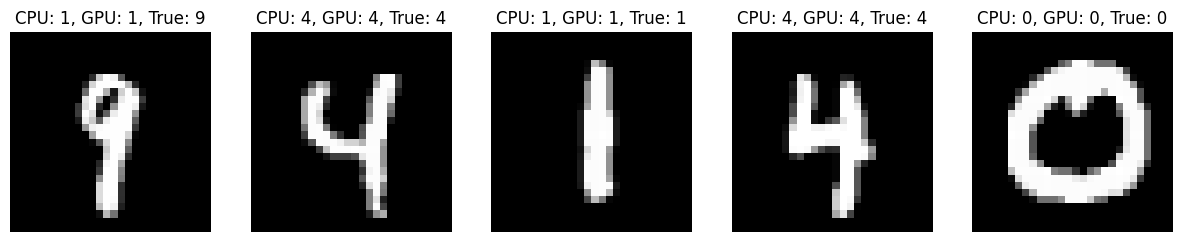

In [34]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    axs[i].imshow(x_in[i].reshape(28, 28).cpu().numpy(), cmap='gray')
    axs[i].set_title(f"CPU: {cpu_pred[i].item()}, GPU: {gpu_pred[i].item()}, True: {y_in[i].item()}")
    axs[i].axis('off')

plt.show()